In [1]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

#link colab https://colab.research.google.com/drive/1NL2J6q2-dkpD0KmtZR2uCPUjiFXukIt4#scrollTo=31_7OBGm9n4z


--2024-12-23 11:41:16--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2024-12-23 11:41:17--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  12.9MB/s    in 5m 0s   

2024-12-23 11:46:18 (12.8 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2024-12-23 11:46:18--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request s

In [2]:
import zipfile
import os

# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))


Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


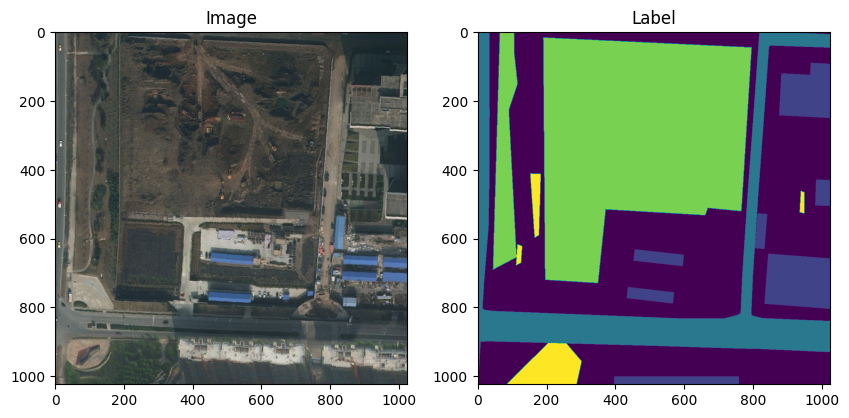

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and visualize an image and its corresponding label
image_path = "Train/Train/Urban/images_png/1366.png"
label_path = "Train/Train/Urban/masks_png/1366.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()


In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None):
        """
        Args:
            root_dir (str): Root directory of the dataset.
            split (str): The split of the dataset, either 'train' or 'val'.
            transform_image (callable, optional): Optional transform to be applied on an image.
            transform_label (callable, optional): Optional transform to be applied on a label.
        """
        self.root_dir = root_dir
        self.split = split  # Can be 'Train' or 'Val'
        self.transform_image = transform_image
        self.transform_label = transform_label

        # Image and Label paths
        self.image_paths = []
        self.label_paths = []

        for subdir in ['Urban', 'Rural']:  # Handling both 'Urban' and 'Rural'
            image_dir = os.path.join(root_dir, split, subdir, 'images_png')
            label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

            for f in os.listdir(image_dir):
                if f.endswith('.png'):  # Assuming the files are PNG images
                    self.image_paths.append(os.path.join(image_dir, f))
                    self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = Image.open(self.label_paths[idx])

        if self.transform_image:
            image = self.transform_image(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label


# Define transformations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode != 'RGB' else x),  # Convert grayscale to RGB
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_label = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),  # Resize masks (use NEAREST to preserve class values)
    transforms.ToTensor(),  # Convert mask to tensor
])

# This assumes that your dataset images are either in RGB or grayscale.
# If they are grayscale, the Lambda function will convert them to RGB format.


#the label is a segmentation mask, which contains categorical values (e.g., class indices) instead of RGB values. We should apply different transformations for the image and label.
#For the image: Apply resizing, normalization, and conversion to tensor.
#For the label: Apply resizing and conversion to tensor, but avoid normalization.

train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)



Reduce the Batch Size: One of the most effective ways to reduce GPU memory usage is to lower the batch size. The batch size determines how many images are processed at once, so reducing it will directly reduce the memory required for storing intermediate activations and gradients.

Use torch.cuda.empty_cache(): PyTorch allows you to manually free up unused memory using torch.cuda.empty_cache(). This is especially useful if you are encountering fragmentation issues during training. You can call this at the end of each epoch to try and clear some memory: torch.cuda.empty_cache()

Gradients Accumulation: Another technique to reduce memory usage is gradient accumulation. Instead of updating the model after every batch, you can accumulate gradients over multiple smaller batches, and then perform a backward pass and optimization step. This way, you can simulate a larger batch size without requiring as much memory.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
!pip install thop
from thop import profile, clever_format
import os

import numpy as np

In [19]:
!git clone https://github.com/XuJiacong/PIDNet.git



fatal: destination path 'PIDNet' already exists and is not an empty directory.


In [20]:
!pip install torch torchvision thop opencv-python tqdm numpy scipy #manually install the necessary libraries:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [21]:
import sys
sys.path.append('/content/PIDNet')

In [22]:
from models.pidnet import get_pred_model

# Initialize PIDNet-S model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_pred_model(name='pidnet_s', num_classes=7).to(device)


In [23]:
# mIoU calculation function
def compute_mIoU(preds, labels, num_classes=7):
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)

    preds = preds.argmax(dim=1)  # Get the class with the highest score for each pixel
    for i in range(num_classes):
        intersection[i] = torch.sum((preds == i) & (labels == i)).float()
        union[i] = torch.sum((preds == i) | (labels == i)).float()

    IoU = intersection / (union + 1e-6)
    mIoU = IoU.mean()
    return mIoU


In [ ]:
import torch.nn.functional as F
# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        outputs = model(images)

        # Upsample model outputs to match the target resolution (512x512)
        outputs = F.interpolate(outputs, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False)

        # Ensure masks are in the right shape and type (long)
        masks = masks.squeeze(1).long()  # Remove extra channel dimension and convert to long

        # Calculate loss
        loss = criterion(outputs, masks)  # Use CrossEntropyLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}] Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            # Upsample the outputs to match the target resolution
            outputs = F.interpolate(outputs, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False)

            # Ensure masks are in the right shape and type (long)
            masks = masks.squeeze(1).long()

            loss = criterion(outputs, masks)
            val_loss += loss.item()

            all_preds.append(outputs)
            all_labels.append(masks)

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Calculate mIoU
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    mIoU = compute_mIoU(all_preds, all_labels)
    print(f"Validation mIoU: {mIoU:.4f}")


Epoch 1/20:   3%|▎         | 40/1261 [00:08<04:18,  4.72it/s]

RuntimeError: output with shape [1, 512, 512] doesn't match the broadcast shape [3, 512, 512] ->

-Output Shape ([1, 512, 512]): This indicates that your input image (after applying the ToTensor() transformation) has a shape of (1, 512, 512). The 1 here likely refers to a single channel (grayscale), instead of the expected 3 channels for RGB images.

-Broadcast Shape ([3, 512, 512]): The normalize() function expects an input tensor with 3 channels (for RGB images) because you provided the mean and standard deviation values for 3 channels: [0.485, 0.456, 0.406] (ImageNet pre-trained model).

In [ ]:
#!cat /content/PIDNet/models/pidnet.py